# Image Captioning Final Project

In this final project you will define and train an image-to-caption model, that can produce descriptions for real world images!

<img src="https://github.com/hse-aml/intro-to-dl/blob/master/week6/images/encoder_decoder.png?raw=1" style="width:70%">

Model architecture: CNN encoder and RNN decoder. 
(https://research.googleblog.com/2014/11/a-picture-is-worth-thousand-coherent.html)

In [1]:
! shred -u setup_google_colab.py
! wget https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py -O setup_google_colab.py
import setup_google_colab
# please, uncomment the week you're working on
# setup_google_colab.setup_week1()
# setup_google_colab.setup_week2()
# setup_google_colab.setup_week3()
# setup_google_colab.setup_week4()
# setup_google_colab.setup_week5()
setup_google_colab.setup_week6()

shred: setup_google_colab.py: failed to open for writing: No such file or directory
--2019-08-18 16:43:54--  https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3792 (3.7K) [text/plain]
Saving to: ‘setup_google_colab.py’

setup_google_colab. 100%[===================>]   3.70K  --.-KB/s    in 0s      

2019-08-18 16:43:54 (70.0 MB/s) - ‘setup_google_colab.py’ saved [3792/3792]

**************************************************
captions_train-val2014.zip
**************************************************
train2014_sample.zip
**************************************************
train_img_embeds.pickle
**************************************************
train_img_fns.pickle
*****************

# Import stuff

In [0]:
import sys
sys.path.append("..")
import grading
import download_utils

In [0]:
download_utils.link_all_keras_resources()

In [4]:
import tensorflow as tf
from tensorflow.contrib import keras
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
L = keras.layers
K = keras.backend
import utils
import time
import zipfile
import json
from collections import defaultdict
import re
import random
from random import choice
import grading_utils
import os
from keras_utils import reset_tf_session
import tqdm_utils

Using TensorFlow backend.


# Prepare the storage for model checkpoints

In [5]:
# Leave USE_GOOGLE_DRIVE = False if you're running locally!
# We recommend to set USE_GOOGLE_DRIVE = True in Google Colab!
# If set to True, we will mount Google Drive, so that you can restore your checkpoint 
# and continue trainig even if your previous Colab session dies.
# If set to True, follow on-screen instructions to access Google Drive (you must have a Google account).
USE_GOOGLE_DRIVE = True

def mount_google_drive():
    from google.colab import drive
    mount_directory = "/content/drive"
    drive.mount(mount_directory)
    drive_root = mount_directory + "/" + list(filter(lambda x: x[0] != '.', os.listdir(mount_directory)))[0] + "/coursera"
    return drive_root

CHECKPOINT_ROOT = ""
if USE_GOOGLE_DRIVE:
    CHECKPOINT_ROOT = mount_google_drive() + "/"

def get_checkpoint_path(epoch=None):
    if epoch is None:
        return os.path.abspath(CHECKPOINT_ROOT + "weights")
    else:
        return os.path.abspath(CHECKPOINT_ROOT + "weights_{}".format(epoch))
      
# example of checkpoint dir
print(get_checkpoint_path(10))

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/coursera/weights_10


# Fill in your Coursera token and email
To successfully submit your answers to our grader, please fill in your Coursera submission token and email

In [0]:
grader = grading.Grader(assignment_key="NEDBg6CgEee8nQ6uE8a7OA", 
                        all_parts=["19Wpv", "uJh73", "yiJkt", "rbpnH", "E2OIL", "YJR7z"])

In [0]:
# token expires every 30 min
COURSERA_TOKEN = ''
COURSERA_EMAIL = ''

# Download data

Takes 10 hours and 20 GB. We've downloaded necessary files for you.

Relevant links (just in case):
- train images http://msvocds.blob.core.windows.net/coco2014/train2014.zip
- validation images http://msvocds.blob.core.windows.net/coco2014/val2014.zip
- captions for both train and validation http://msvocds.blob.core.windows.net/annotations-1-0-3/captions_train-val2014.zip

In [0]:
# we downloaded them for you, just link them here
download_utils.link_week_6_resources()

# Extract image features

We will use pre-trained InceptionV3 model for CNN encoder (https://research.googleblog.com/2016/03/train-your-own-image-classifier-with.html) and extract its last hidden layer as an embedding:

<img src="https://github.com/hse-aml/intro-to-dl/blob/master/week6/images/inceptionv3.png?raw=1" style="width:70%">

In [0]:
IMG_SIZE = 299

In [0]:
# we take the last hidden layer of IncetionV3 as an image embedding
def get_cnn_encoder():
    K.set_learning_phase(False)
    model = keras.applications.InceptionV3(include_top=False)
    preprocess_for_model = keras.applications.inception_v3.preprocess_input

    model = keras.models.Model(model.inputs, keras.layers.GlobalAveragePooling2D()(model.output))
    return model, preprocess_for_model

Features extraction takes too much time on CPU:
- Takes 16 minutes on GPU.
- 25x slower (InceptionV3) on CPU and takes 7 hours.
- 10x slower (MobileNet) on CPU and takes 3 hours.

So we've done it for you with the following code:
```python
# load pre-trained model
reset_tf_session()
encoder, preprocess_for_model = get_cnn_encoder()

# extract train features
train_img_embeds, train_img_fns = utils.apply_model(
    "train2014.zip", encoder, preprocess_for_model, input_shape=(IMG_SIZE, IMG_SIZE))
utils.save_pickle(train_img_embeds, "train_img_embeds.pickle")
utils.save_pickle(train_img_fns, "train_img_fns.pickle")

# extract validation features
val_img_embeds, val_img_fns = utils.apply_model(
    "val2014.zip", encoder, preprocess_for_model, input_shape=(IMG_SIZE, IMG_SIZE))
utils.save_pickle(val_img_embeds, "val_img_embeds.pickle")
utils.save_pickle(val_img_fns, "val_img_fns.pickle")

# sample images for learners
def sample_zip(fn_in, fn_out, rate=0.01, seed=42):
    np.random.seed(seed)
    with zipfile.ZipFile(fn_in) as fin, zipfile.ZipFile(fn_out, "w") as fout:
        sampled = filter(lambda _: np.random.rand() < rate, fin.filelist)
        for zInfo in sampled:
            fout.writestr(zInfo, fin.read(zInfo))
            
sample_zip("train2014.zip", "train2014_sample.zip")
sample_zip("val2014.zip", "val2014_sample.zip")
```

In [11]:
# load prepared embeddings
train_img_embeds = utils.read_pickle("train_img_embeds.pickle")
train_img_fns = utils.read_pickle("train_img_fns.pickle")
val_img_embeds = utils.read_pickle("val_img_embeds.pickle")
val_img_fns = utils.read_pickle("val_img_fns.pickle")
# check shapes
print(train_img_embeds.shape, len(train_img_fns))
print(val_img_embeds.shape, len(val_img_fns))

(82783, 2048) 82783
(40504, 2048) 40504


In [12]:
# check prepared samples of images
list(filter(lambda x: x.endswith("_sample.zip"), os.listdir(".")))

['val2014_sample.zip', 'train2014_sample.zip']

# Extract captions for images

In [13]:
# extract captions from zip
def get_captions_for_fns(fns, zip_fn, zip_json_path):
    zf = zipfile.ZipFile(zip_fn)
    j = json.loads(zf.read(zip_json_path).decode("utf8"))
    id_to_fn = {img["id"]: img["file_name"] for img in j["images"]}
    fn_to_caps = defaultdict(list)
    for cap in j['annotations']:
        fn_to_caps[id_to_fn[cap['image_id']]].append(cap['caption'])
    fn_to_caps = dict(fn_to_caps)
    return list(map(lambda x: fn_to_caps[x], fns))
    
train_captions = get_captions_for_fns(train_img_fns, "captions_train-val2014.zip", 
                                      "annotations/captions_train2014.json")

val_captions = get_captions_for_fns(val_img_fns, "captions_train-val2014.zip", 
                                      "annotations/captions_val2014.json")

# check shape
print(len(train_img_fns), len(train_captions))
print(len(val_img_fns), len(val_captions))

82783 82783
40504 40504


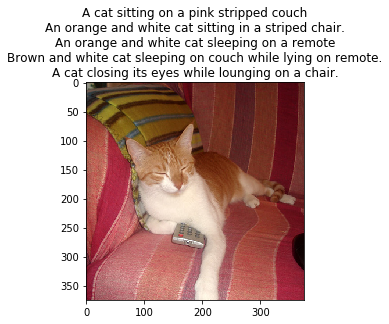

In [14]:
# look at training example (each has 5 captions)
def show_trainig_example(train_img_fns, train_captions, example_idx=0):
    """
    You can change example_idx and see different images
    """
    zf = zipfile.ZipFile("train2014_sample.zip")
    captions_by_file = dict(zip(train_img_fns, train_captions))
    all_files = set(train_img_fns)
    found_files = list(filter(lambda x: x.filename.rsplit("/")[-1] in all_files, zf.filelist))
    example = found_files[example_idx]
    img = utils.decode_image_from_buf(zf.read(example))
    plt.imshow(utils.image_center_crop(img))
    plt.title("\n".join(captions_by_file[example.filename.rsplit("/")[-1]]))
    plt.show()
    
show_trainig_example(train_img_fns, train_captions, example_idx=142)

# Prepare captions for training

In [15]:
# preview captions data
train_captions[:2]

[['A long dirt road going through a forest.',
  'A SCENE OF WATER AND A PATH WAY',
  'A sandy path surrounded by trees leads to a beach.',
  'Ocean view through a dirt road surrounded by a forested area. ',
  'dirt path leading beneath barren trees to open plains'],
 ['A group of zebra standing next to each other.',
  'This is an image of of zebras drinking',
  'ZEBRAS AND BIRDS SHARING THE SAME WATERING HOLE',
  'Zebras that are bent over and drinking water together.',
  'a number of zebras drinking water near one another']]

In [0]:
# special tokens
PAD = "#PAD#"
UNK = "#UNK#"
START = "#START#"
END = "#END#"

from collections import Counter

# split sentence into tokens (split into lowercased words)
def split_sentence(sentence):
    return list(filter(lambda x: len(x) > 0, re.split('\W+', sentence.lower())))

def generate_vocabulary(train_captions):
    """
    Return {token: index} for all train tokens (words) that occur 5 times or more, 
        `index` should be from 0 to N, where N is a number of unique tokens in the resulting dictionary.
    Use `split_sentence` function to split sentence into tokens.
    Also, add PAD (for batch padding), UNK (unknown, out of vocabulary), 
        START (start of sentence) and END (end of sentence) tokens into the vocabulary.
    """
    ranking = Counter()
    for captions in train_captions:
      for sentence in captions:
        ranking.update(split_sentence(sentence))
    
    vocab = [word for word, count in ranking.most_common() if count >=5]
    vocab.extend([PAD, UNK, START, END])
    return {token: index for index, token in enumerate(sorted(vocab))}
    
def caption_tokens_to_indices(captions, vocab):
    """
    `captions` argument is an array of arrays:
    [
        [
            "image1 caption1",
            "image1 caption2",
            ...
        ],
        [
            "image2 caption1",
            "image2 caption2",
            ...
        ],
        ...
    ]
    Use `split_sentence` function to split sentence into tokens.
    Replace all tokens with vocabulary indices, use UNK for unknown words (out of vocabulary).
    Add START and END tokens to start and end of each sentence respectively.
    For the example above you should produce the following:
    [
        [
            [vocab[START], vocab["image1"], vocab["caption1"], vocab[END]],
            [vocab[START], vocab["image1"], vocab["caption2"], vocab[END]],
            ...
        ],
        ...
    ]
    """
    res = []
    for data in captions:
      res_set = []
      for sentence in data:
        if len(sentence) > 0:
          _res = [vocab[START]]
          for word in split_sentence(sentence):
            try:
              _res.append(vocab[word])
            except KeyError:
              _res.append(vocab[UNK])
          _res.append(vocab[END])
          res_set.append(_res)
      res.append(res_set)
    return res

In [0]:
# Simple vocabulary generator test
s = ["What are you talking about?"]
must_have = [PAD, UNK, START, END]
expected_len = len(s[0].split(' ')) + len(must_have)

v = generate_vocabulary([s] * 5)

assert len(v) == expected_len
for word in must_have:
  assert word in v.keys()

In [0]:
# Simple captions2index test
c = [
    [
        "This is a pen.",
        "A pen it is."
    ],
]
v = {
    "a": 0,
    "pen": 1,
    "this": 2,
    "is": 3,
    "an": 4,
    START: 5,
    END: 6,
    UNK: 7
}
expected = [[
  [v[START], v["this"], v["is"], v["a"], v["pen"], v[END]],
  [v[START], v["a"], v["pen"], v[UNK], v["is"], v[END]],
]]
result = caption_tokens_to_indices(c, v)
assert result == expected

In [19]:
# prepare vocabulary
vocab = generate_vocabulary(train_captions)
vocab_inverse = {idx: w for w, idx in vocab.items()}
print(len(vocab))

8769


In [0]:
# replace tokens with indices
train_captions_indexed = caption_tokens_to_indices(train_captions, vocab)
val_captions_indexed = caption_tokens_to_indices(val_captions, vocab)

Captions have different length, but we need to batch them, that's why we will add PAD tokens so that all sentences have an equal length. 

We will crunch LSTM through all the tokens, but we will ignore padding tokens during loss calculation.

In [0]:
# we will use this during training
def batch_captions_to_matrix(batch_captions, pad_idx, max_len=None):
    """
    `batch_captions` is an array of arrays:
    [
        [vocab[START], ..., vocab[END]],
        [vocab[START], ..., vocab[END]],
        ...
    ]
    Put vocabulary indexed captions into np.array of shape (len(batch_captions), columns),
        where "columns" is max(map(len, batch_captions)) when max_len is None
        and "columns" = min(max_len, max(map(len, batch_captions))) otherwise.
    Add padding with pad_idx where necessary.
    Input example: [[1, 2, 3], [4, 5]]
    Output example: np.array([[1, 2, 3], [4, 5, pad_idx]]) if max_len=None
    Output example: np.array([[1, 2], [4, 5]]) if max_len=2
    Output example: np.array([[1, 2, 3], [4, 5, pad_idx]]) if max_len=100
    Try to use numpy, we need this function to be fast!
    """
    nrows = len(batch_captions)
    ncols = max([len(bc) for bc in batch_captions])
    if max_len is not None:
      ncols = min([max_len, ncols])
    matrix = np.zeros((nrows, ncols), dtype=np.int16) + pad_idx

    for idx in range(nrows):
      code = batch_captions[idx][:max_len]
      matrix[idx,:len(code)] = code
      
    return matrix

In [0]:
# Test batch2matrix
v = {
    "a": 0,
    "pen": 1,
    "this": 2,
    "is": 3,
    "an": 4,
    START: 5,
    END: 6,
    UNK: 7,
    PAD: 8,
}
b = [
  [v[START], v["this"], v["is"], v["a"], v["pen"], v[END]], # 6
  [v[START], v["pen"], v[UNK], v["is"], v[END]],            # 5
]

# Do we use padding?
t1 = np.array([
  [v[START], v["this"], v["is"], v["a"], v["pen"], v[END]], # 6
  [v[START], v["pen"], v[UNK], v["is"], v[END], v[PAD]],    # 6
])
assert np.array_equal(batch_captions_to_matrix(b, v[PAD], max_len=None), t1)

# Can we shorten the max length?
t2 = np.array([
  [v[START], v["this"]], # 2
  [v[START], v["pen"]],  # 2
])
assert np.array_equal(batch_captions_to_matrix(b, v[PAD], max_len=2), t2)

In [0]:
## GRADED PART, DO NOT CHANGE!
# Vocabulary creation
grader.set_answer("19Wpv", grading_utils.test_vocab(vocab, PAD, UNK, START, END))
# Captions indexing
grader.set_answer("uJh73", grading_utils.test_captions_indexing(train_captions_indexed, vocab, UNK))
# Captions batching
grader.set_answer("yiJkt", grading_utils.test_captions_batching(batch_captions_to_matrix))

In [0]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

You used an invalid email or your token may have expired. Please make sure you have entered all fields correctly. Try generating a new token if the issue still persists.


In [0]:
# make sure you use correct argument in caption_tokens_to_indices
assert len(caption_tokens_to_indices(train_captions[:10], vocab)) == 10
assert len(caption_tokens_to_indices(train_captions[:5], vocab)) == 5

# Training

## Define architecture

Since our problem is to generate image captions, RNN text generator should be conditioned on image. The idea is to use image features as an initial state for RNN instead of zeros. 

Remember that you should transform image feature vector to RNN hidden state size by fully-connected layer and then pass it to RNN.

During training we will feed ground truth tokens into the lstm to get predictions of next tokens. 

Notice that we don't need to feed last token (END) as input (http://cs.stanford.edu/people/karpathy/):

<img src="https://github.com/hse-aml/intro-to-dl/blob/master/week6/images/encoder_decoder_explained.png?raw=1" style="width:50%">

In [0]:
IMG_EMBED_SIZE = train_img_embeds.shape[1]
IMG_EMBED_BOTTLENECK = 120
WORD_EMBED_SIZE = 100
LSTM_UNITS = 300
LOGIT_BOTTLENECK = 120
pad_idx = vocab[PAD]

In [25]:
# remember to reset your graph if you want to start building it from scratch!
s = reset_tf_session()
tf.set_random_seed(42)

W0818 16:45:36.722266 140195296298880 deprecation_wrapper.py:119] From /content/keras_utils.py:68: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0818 16:45:36.724144 140195296298880 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:79: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0818 16:45:36.726644 140195296298880 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:82: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0818 16:45:36.741909 140195296298880 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:84: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0818 16:45:36.742788 140195296298880 deprecation_wrapper.py:119] F

Here we define decoder graph.

We use Keras layers where possible because we can use them in functional style with weights reuse like this:
```python
dense_layer = L.Dense(42, input_shape=(None, 100) activation='relu')
a = tf.placeholder('float32', [None, 100])
b = tf.placeholder('float32', [None, 100])
dense_layer(a)  # that's how we applied dense layer!
dense_layer(b)  # and again
```

Here's a figure to help you with flattening in decoder:
<img src="https://github.com/hse-aml/intro-to-dl/blob/master/week6/images/flatten_help.jpg?raw=1" style="width:80%">

In [26]:
s = reset_tf_session()

class decoder:
    # [batch_size, IMG_EMBED_SIZE] of CNN image features
    img_embeds = tf.placeholder('float32', [None, IMG_EMBED_SIZE])
    # [batch_size, time steps] of word ids
    sentences = tf.placeholder('int32', [None, None])
    
    # we use bottleneck here to reduce the number of parameters
    # image embedding -> bottleneck
    img_embed_to_bottleneck = L.Dense(IMG_EMBED_BOTTLENECK, 
                                      input_shape=(None, IMG_EMBED_SIZE), 
                                      activation='elu')
    # image embedding bottleneck -> lstm initial state
    img_embed_bottleneck_to_h0 = L.Dense(LSTM_UNITS,
                                         input_shape=(None, IMG_EMBED_BOTTLENECK),
                                         activation='elu')
    # word -> embedding
    word_embed = L.Embedding(len(vocab), WORD_EMBED_SIZE)
    # lstm cell (from tensorflow)
    lstm = tf.nn.rnn_cell.LSTMCell(LSTM_UNITS)
    
    # we use bottleneck here to reduce model complexity
    # lstm output -> logits bottleneck
    token_logits_bottleneck = L.Dense(LOGIT_BOTTLENECK, 
                                      input_shape=(None, LSTM_UNITS),
                                      activation="elu")
    # logits bottleneck -> logits for next token prediction
    token_logits = L.Dense(len(vocab),
                           input_shape=(None, LOGIT_BOTTLENECK))
    
    # initial lstm cell state of shape (None, LSTM_UNITS),
    # we need to condition it on `img_embeds` placeholder.
    c0 = h0 = img_embed_bottleneck_to_h0(
        img_embed_to_bottleneck(img_embeds)
        )
    
    # embed all tokens but the last for lstm input,
    # remember that L.Embedding is callable,
    # use `sentences` placeholder as input.
    word_embeds = word_embed(sentences[:,:-1])

    # during training we use ground truth tokens `word_embeds` as context for next token prediction.
    # that means that we know all the inputs for our lstm and can get 
    # all the hidden states with one tensorflow operation (tf.nn.dynamic_rnn).
    # `hidden_states` has a shape of [batch_size, time steps, LSTM_UNITS].
    hidden_states, _ = tf.nn.dynamic_rnn(lstm, word_embeds,
                                         initial_state=tf.nn.rnn_cell.LSTMStateTuple(c0, h0))
    
    # now we need to calculate token logits for all the hidden states
    
    # first, we reshape `hidden_states` to [-1, LSTM_UNITS]
    flat_hidden_states = tf.reshape(hidden_states, (-1, LSTM_UNITS))

    # then, we calculate logits for next tokens using `token_logits_bottleneck` and `token_logits` layers
    flat_token_logits = token_logits(
        token_logits_bottleneck(flat_hidden_states)
        )

    # then, we flatten the ground truth token ids.
    # remember, that we predict next tokens for each time step,
    # use `sentences` placeholder.
    flat_ground_truth = tf.reshape(sentences[:,1:], (tf.shape(sentences)[0] * (tf.shape(sentences)[1] - 1),))

    # we need to know where we have real tokens (not padding) in `flat_ground_truth`,
    # we don't want to propagate the loss for padded output tokens,
    # fill `flat_loss_mask` with 1.0 for real tokens (not pad_idx) and 0.0 otherwise.
    pad_mask = tf.math.equal(flat_ground_truth, tf.zeros_like(flat_ground_truth) + vocab[PAD])
    flat_loss_mask = tf.where_v2(pad_mask,
                                 x=tf.zeros_like(flat_ground_truth, dtype=tf.float32),
                                 y=tf.ones_like(flat_ground_truth, dtype=tf.float32))

    # compute cross-entropy between `flat_ground_truth` and `flat_token_logits` predicted by lstm
    xent = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=flat_ground_truth, 
        logits=flat_token_logits
    )

    # compute average `xent` over tokens with nonzero `flat_loss_mask`.
    # we don't want to account misclassification of PAD tokens, because that doesn't make sense,
    # we have PAD tokens for batching purposes only!
    loss = tf.reduce_mean(xent * flat_loss_mask)
    #loss = tf.reduce_mean(tf.boolean_mask(xent, flat_loss_mask))

W0818 16:45:37.965114 140195296298880 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0818 16:45:37.971153 140195296298880 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0818 16:45:37.973583 140195296298880 deprecation.py:323] From <ipython-input-26-aa9496c6a656>:21: LSTMCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a futu

In [0]:
# define optimizer operation to minimize the loss
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_step = optimizer.minimize(decoder.loss)

# will be used to save/load network weights.
# you need to reset your default graph and define it in the same way to be able to load the saved weights!
saver = tf.train.Saver()

# intialize all variables
s.run(tf.global_variables_initializer())

In [0]:
## GRADED PART, DO NOT CHANGE!
# Decoder shapes test
grader.set_answer("rbpnH", grading_utils.test_decoder_shapes(decoder, IMG_EMBED_SIZE, vocab, s))
# Decoder random loss test
grader.set_answer("E2OIL", grading_utils.test_random_decoder_loss(decoder, IMG_EMBED_SIZE, vocab, s))

In [0]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

You used an invalid email or your token may have expired. Please make sure you have entered all fields correctly. Try generating a new token if the issue still persists.


## Training loop
Evaluate train and validation metrics through training and log them. Ensure that loss decreases.

In [0]:
train_captions_indexed = np.array(train_captions_indexed)
val_captions_indexed = np.array(val_captions_indexed)

In [0]:
# generate batch via random sampling of images and captions for them,
# we use `max_len` parameter to control the length of the captions (truncating long captions)
def generate_batch(images_embeddings, indexed_captions, batch_size, max_len=None):
    """
    `images_embeddings` is a np.array of shape [number of images, IMG_EMBED_SIZE].
    `indexed_captions` holds 5 vocabulary indexed captions for each image:
    [
        [
            [vocab[START], vocab["image1"], vocab["caption1"], vocab[END]],
            [vocab[START], vocab["image1"], vocab["caption2"], vocab[END]],
            ...
        ],
        ...
    ]
    Generate a random batch of size `batch_size`.
    Take random images and choose one random caption for each image.
    Remember to use `batch_captions_to_matrix` for padding and respect `max_len` parameter.
    Return feed dict {decoder.img_embeds: ..., decoder.sentences: ...}.
    """
    assert images_embeddings.shape[0] == len(indexed_captions)
    choices = images_embeddings.shape[0]
    selection = np.random.choice(np.arange(choices), size=batch_size, replace=False)

    batch_image_embeddings = images_embeddings[selection]
    captions = [random.choice(indexed_captions[i]) for i in selection]
    batch_captions_matrix = batch_captions_to_matrix(captions, vocab[PAD], max_len=max_len)
    
    return {decoder.img_embeds: batch_image_embeddings, 
            decoder.sentences: batch_captions_matrix}



class BatchGen:
  def __init__(self, images_embeddings, indexed_captions, batch_size, max_len=None):
    assert images_embeddings.shape[0] == len(indexed_captions)
    self.batch_size = batch_size
    self.max_len = max_len

    self.images_embeddings = []
    self.indexed_captions = []
    for idx, captions in enumerate(indexed_captions):
      self.indexed_captions.extend([[caption] for caption in captions])
      self.images_embeddings.extend([images_embeddings[idx]] * len(captions))
    self.images_embeddings = np.array(self.images_embeddings)
    assert self.images_embeddings.shape[0] == len(self.indexed_captions)
    assert self.images_embeddings.shape == (sum([len(c) for c in indexed_captions]), images_embeddings.shape[1])

    self.available = self.images_embeddings.shape[0]

  def iterator(self):
    while self.available > 0:
      selection = np.random.choice(np.arange(self.available), size=self.batch_size, replace=False)
      #print(f'Will use IDs. Head: {selection[:5]}...')
      batch_image_embeddings = self.images_embeddings[selection]
      captions = [self.indexed_captions[i][0] for i in selection]
      batch_captions_matrix = batch_captions_to_matrix(captions, vocab[PAD], max_len=self.max_len)
    
      yield {decoder.img_embeds: batch_image_embeddings, 
              decoder.sentences: batch_captions_matrix}

      self.available -= self.batch_size

In [30]:
#generate_batch(train_img_embeds, train_captions_indexed, batch_size, 20)
bg = BatchGen(train_img_embeds, train_captions_indexed, 5, 20)
for batch in bg.iterator():
  print(batch)
  break

{<tf.Tensor 'Placeholder:0' shape=(?, 2048) dtype=float32>: array([[0.278812  , 0.31016237, 0.6644132 , ..., 0.48531133, 0.09202851,
        0.35043368],
       [0.05124001, 0.1915426 , 0.10984574, ..., 0.02067464, 0.44306207,
        0.02115202],
       [0.06070239, 0.40001473, 0.0283587 , ..., 0.508809  , 0.12923512,
        0.8711558 ],
       [0.32954237, 0.08719851, 0.46036974, ..., 0.01760171, 0.06040315,
        0.43048134],
       [0.06865288, 0.292806  , 1.3648417 , ..., 0.4060051 , 0.6453166 ,
        0.05948183]], dtype=float32), <tf.Tensor 'Placeholder_1:0' shape=(?, ?) dtype=int32>: array([[   2,   54, 4552,  249,   54, 2870,  330, 3736,   54, 1524, 8181,
           0,    1,    1,    1],
       [   2,   54, 4558, 7853,   54, 3163, 7848, 7677, 3416,    0,    1,
           1,    1,    1,    1],
       [   2,   54, 5566, 6305,   54, 5323, 5127, 6939,   80,   54, 2892,
           0,    1,    1,    1],
       [   2, 7817, 3998,   54, 4558, 7296, 3885, 7804, 6372,    0,    1,
  

In [0]:
batch_size = 64
n_epochs = 100
n_batches_per_epoch = len(train_img_embeds) // batch_size
n_validation_batches = 100  # how many batches are used for validation after each epoch

In [32]:
# you can load trained weights here
# uncomment the next line if you need to load weights

start_epoch=100
saver.restore(s, get_checkpoint_path(epoch=start_epoch))

W0818 16:46:00.689154 140195296298880 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


Look at the training and validation loss, they should be decreasing!

In [33]:
!ls '/content/drive/My Drive/coursera'

backup				 weights_98.index
checkpoint			 weights_98.meta
weights_100.data-00000-of-00001  weights_99.data-00000-of-00001
weights_100.index		 weights_99.index
weights_100.meta		 weights_99.meta
weights_97.data-00000-of-00001	 weights.data-00000-of-00001
weights_97.index		 weights.index
weights_97.meta			 weights.meta
weights_98.data-00000-of-00001


In [0]:
# actual training loop
MAX_LEN = 20  # truncate long captions to speed up training

# to make training reproducible
np.random.seed(42)
random.seed(42)

from tqdm import tqdm
from time import sleep

for epoch in range(start_epoch, start_epoch+n_epochs):
    
    train_loss = 0
    bg = BatchGen(train_img_embeds, train_captions_indexed, batch_size, MAX_LEN)
    with tqdm(total=n_batches_per_epoch, file=sys.stdout) as pbar:
      for batch_id, batch in enumerate(bg.iterator()):
        if batch_id >= n_batches_per_epoch:
          break
        train_loss += s.run([decoder.loss, train_step], batch)[0]
        pbar.set_description(f'{train_loss/(batch_id+1)}')
        pbar.update(1)
        sleep(0.01)
        
    train_loss /= n_batches_per_epoch
    print(f"\nTraining loss: {train_loss}")
    
    val_loss = 0
    bg = BatchGen(val_img_embeds, val_captions_indexed, batch_size, MAX_LEN)
    for batch_id, batch in enumerate(bg.iterator()):
      if batch_id >= n_validation_batches:
        break
      val_loss += s.run(decoder.loss, batch)
    val_loss /= n_validation_batches
    
    print('Epoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

    # save weights after finishing epoch
    save_path = get_checkpoint_path(epoch)
    print(f"Saving weights to {save_path}")
    saver.save(s, save_path)
    print()
    
print("Finished!")

2.5910719060565923: 100%|██████████| 1293/1293 [01:02<00:00, 20.54it/s]

Training loss: 2.5910719060565923
Epoch: 1, train loss: 2.5910719060565923, val loss: 2.1952860045433042
Saving weights to /content/drive/My Drive/coursera/weights_1

1.977331230830335: 100%|██████████| 1293/1293 [01:03<00:00, 22.31it/s]

Training loss: 1.977331230830335
Epoch: 2, train loss: 1.977331230830335, val loss: 1.9071152937412261
Saving weights to /content/drive/My Drive/coursera/weights_2

1.8120252465611728: 100%|██████████| 1293/1293 [01:03<00:00, 21.44it/s]

Training loss: 1.8120252465611728
Epoch: 3, train loss: 1.8120252465611728, val loss: 1.7944112920761108
Saving weights to /content/drive/My Drive/coursera/weights_3

1.7275096821582143: 100%|██████████| 1293/1293 [01:03<00:00, 20.27it/s]

Training loss: 1.7275096821582143
Epoch: 4, train loss: 1.7275096821582143, val loss: 1.7352087259292603
Saving weights to /content/drive/My Drive/coursera/weights_4

1.6787208431189315: 100%|██████████| 1293/1

In [0]:
## GRADED PART, DO NOT CHANGE!
# Validation loss
grader.set_answer("YJR7z", grading_utils.test_validation_loss(
    decoder, s, generate_batch, val_img_embeds, val_captions_indexed))

**************************************************



In [0]:
# you can make submission with answers so far to check yourself at this stage

COURSERA_TOKEN = ''

grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!


In [0]:
# check that it's learnt something, outputs accuracy of next word prediction (should be around 0.5)
from sklearn.metrics import accuracy_score, log_loss

def decode_sentence(sentence_indices):
    return " ".join(list(map(vocab_inverse.get, sentence_indices)))

def check_after_training(n_examples):
    fd = generate_batch(train_img_embeds, train_captions_indexed, batch_size)
    logits = decoder.flat_token_logits.eval(fd)
    truth = decoder.flat_ground_truth.eval(fd)
    mask = decoder.flat_loss_mask.eval(fd).astype(bool)
    print("Loss:", decoder.loss.eval(fd))
    print("Accuracy:", accuracy_score(logits.argmax(axis=1)[mask], truth[mask]))
    for example_idx in range(n_examples):
        print("Example", example_idx)
        print("Predicted:", decode_sentence(logits.argmax(axis=1).reshape((batch_size, -1))[example_idx]))
        print("Truth:", decode_sentence(truth.reshape((batch_size, -1))[example_idx]))
        print("")

check_after_training(3)

Loss: 0.9886612
Accuracy: 0.5313351498637602
Example 0
Predicted: a cats sitting on a ground of a and up a window #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END#
Truth: two birds sitting on the backs of chairs looking out a window #END# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD#

Example 1
Predicted: a colorful umbrellas are open on a field #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# and and and and
Truth: many colorful umbrellas lay open on a field #END# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD#

Example 2
Predicted: a man is down a room room with a remote #END# front #END# movies #END# #END# #END# #END# #END# #END# #END# #END# and
Truth: a man walking into a living room with a bicycle in it #END# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD#



### Output from the model that passed grading

```
Loss: 2.2464094
Accuracy: 0.5123216601815823
Example 0
Predicted: a young is his teeth of a small #END# on a bed #END# #END# #END# #END# #END# #END# #END# #END#
Truth: a man brushing the teeth of a baby lying on the bed #END# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD#

Example 1
Predicted: a man is through the air while riding a skateboard board #END# #END# #END# #END# #END# #END# #END# #END# #END#
Truth: a man flying through the air while riding a skate board #END# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD#

Example 2
Predicted: a and wine from sitting looks a in a room #END# #END# #END# #END# #END# #END# #END# #END# #END# #END#
Truth: woman drinking coffee while man prepares food in a kitchen #END# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD#
```

### Output from the model I made (slightly different model and batching strategy)

```
Loss: 0.9886612
Accuracy: 0.5313351498637602
Example 0
Predicted: a cats sitting on a ground of a and up a window #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END#
Truth: two birds sitting on the backs of chairs looking out a window #END# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD#

Example 1
Predicted: a colorful umbrellas are open on a field #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# and and and and
Truth: many colorful umbrellas lay open on a field #END# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD#

Example 2
Predicted: a man is down a room room with a remote #END# front #END# movies #END# #END# #END# #END# #END# #END# #END# #END# and
Truth: a man walking into a living room with a bicycle in it #END# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD#
```

In [0]:
# save last graph weights to file!
saver.save(s, get_checkpoint_path())

'/content/drive/My Drive/coursera/weights'

# Applying model

Here we construct a graph for our final model.

It will work as follows:
- take an image as an input and embed it
- condition lstm on that embedding
- predict the next token given a START input token
- use predicted token as an input at next time step
- iterate until you predict an END token

In [0]:
class final_model:
    # CNN encoder
    encoder, preprocess_for_model = get_cnn_encoder()
    saver.restore(s, get_checkpoint_path())  # keras applications corrupt our graph, so we restore trained weights
    
    # containers for current lstm state
    lstm_c = tf.Variable(tf.zeros([1, LSTM_UNITS]), name="cell")
    lstm_h = tf.Variable(tf.zeros([1, LSTM_UNITS]), name="hidden")

    # input images
    input_images = tf.placeholder('float32', [1, IMG_SIZE, IMG_SIZE, 3], name='images')

    # get image embeddings
    img_embeds = encoder(input_images)

    # initialize lstm state conditioned on image
    init_c = init_h = decoder.img_embed_bottleneck_to_h0(decoder.img_embed_to_bottleneck(img_embeds))
    init_lstm = tf.assign(lstm_c, init_c), tf.assign(lstm_h, init_h)
    
    # current word index
    current_word = tf.placeholder('int32', [1], name='current_input')

    # embedding for current word
    word_embed = decoder.word_embed(current_word)

    # apply lstm cell, get new lstm states
    new_c, new_h = decoder.lstm(word_embed, tf.nn.rnn_cell.LSTMStateTuple(lstm_c, lstm_h))[1]

    # compute logits for next token
    new_logits = decoder.token_logits(decoder.token_logits_bottleneck(new_h))
    # compute probabilities for next token
    new_probs = tf.nn.softmax(new_logits)

    # `one_step` outputs probabilities of next token and updates lstm hidden state
    one_step = new_probs, tf.assign(lstm_c, new_c), tf.assign(lstm_h, new_h)

In [35]:
# look at how temperature works for probability distributions
# for high temperature we have more uniform distribution
_ = np.array([0.5, 0.4, 0.1])
for t in [0.01, 0.1, 1, 10, 100]:
    print(" ".join(map(str, _**(1/t) / np.sum(_**(1/t)))), "with temperature", t)

0.9999999997962965 2.0370359759195462e-10 1.2676505999700117e-70 with temperature 0.01
0.9030370433250645 0.09696286420394223 9.247099323648666e-08 with temperature 0.1
0.5 0.4 0.1 with temperature 1
0.35344772639219624 0.34564811360592396 0.3009041600018798 with temperature 10
0.33536728048099185 0.33461976434857876 0.3300129551704294 with temperature 100


In [0]:
# this is an actual prediction loop
def generate_caption(image, t=1, sample=False, max_len=20):
    """
    Generate caption for given image.
    if `sample` is True, we will sample next token from predicted probability distribution.
    `t` is a temperature during that sampling,
        higher `t` causes more uniform-like distribution = more chaos.
    """
    # condition lstm on the image
    s.run(final_model.init_lstm, 
          {final_model.input_images: [image]})
    
    # current caption
    # start with only START token
    caption = [vocab[START]]
    
    for _ in range(max_len):
        next_word_probs = s.run(final_model.one_step, 
                                {final_model.current_word: [caption[-1]]})[0]
        next_word_probs = next_word_probs.ravel()
        
        # apply temperature
        next_word_probs = next_word_probs**(1/t) / np.sum(next_word_probs**(1/t))

        if sample:
            next_word = np.random.choice(range(len(vocab)), p=next_word_probs)
        else:
            next_word = np.argmax(next_word_probs)

        caption.append(next_word)
        if next_word == vocab[END]:
            break
       
    return list(map(vocab_inverse.get, caption))

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


a baseball player is getting ready to hit a ball


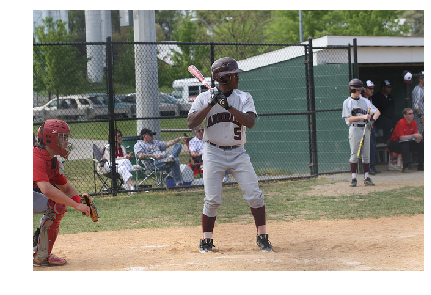

In [37]:
# look at validation prediction example
def apply_model_to_image_raw_bytes(raw):
    img = utils.decode_image_from_buf(raw)
    fig = plt.figure(figsize=(7, 7))
    plt.grid('off')
    plt.axis('off')
    plt.imshow(img)
    img = utils.crop_and_preprocess(img, (IMG_SIZE, IMG_SIZE), final_model.preprocess_for_model)
    print(' '.join(generate_caption(img)[1:-1]))
    plt.show()

def show_valid_example(val_img_fns, example_idx=0):
    zf = zipfile.ZipFile("val2014_sample.zip")
    all_files = set(val_img_fns)
    found_files = list(filter(lambda x: x.filename.rsplit("/")[-1] in all_files, zf.filelist))
    example = found_files[example_idx]
    apply_model_to_image_raw_bytes(zf.read(example))
    
show_valid_example(val_img_fns, example_idx=100)

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


a clock tower with a clock on the top of it


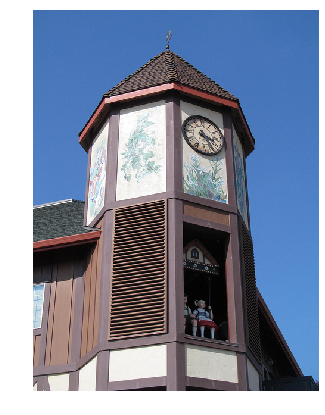

a cat is sitting on top of a computer keyboard


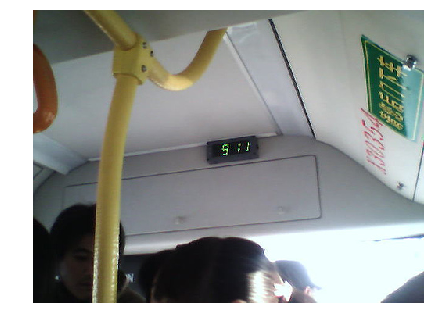

a cat is sitting in front of a laptop


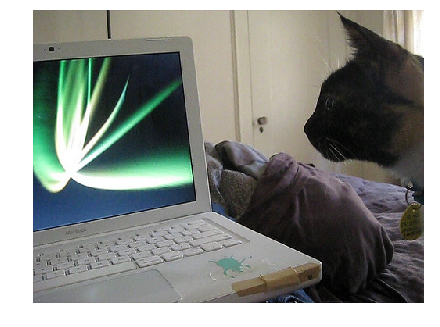

a kitchen with a table and chairs and a table


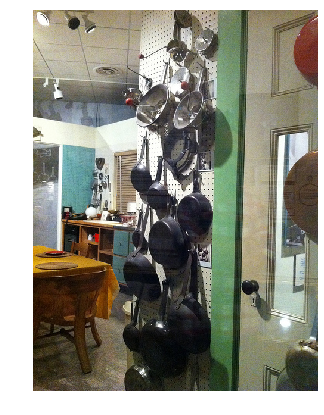

a woman standing on a sidewalk next to a suitcase


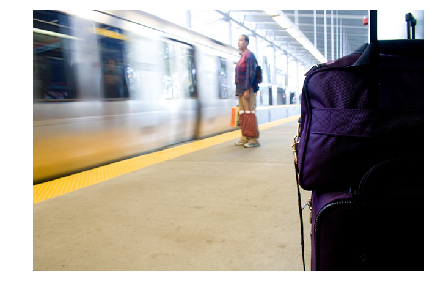

a brown and white dog is standing in a field of grass


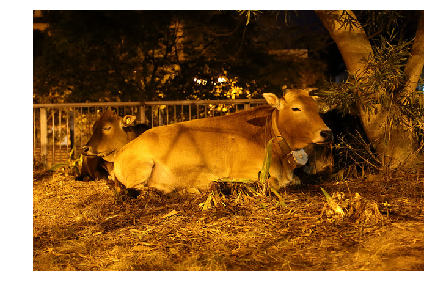

a double decker bus is shown with a clock


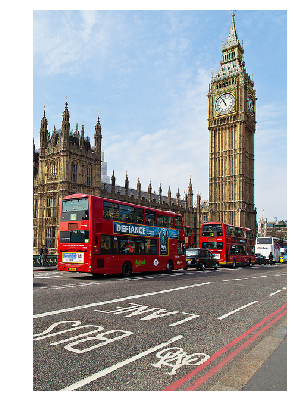

a train is parked on the tracks in a station


a kitchen with a stove and a microwave


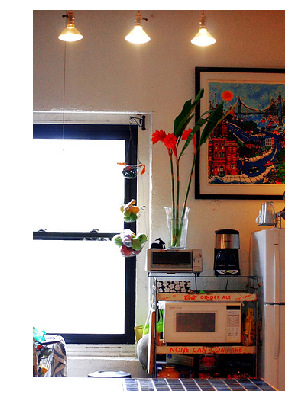

a large jetliner sitting on top of an airport tarmac


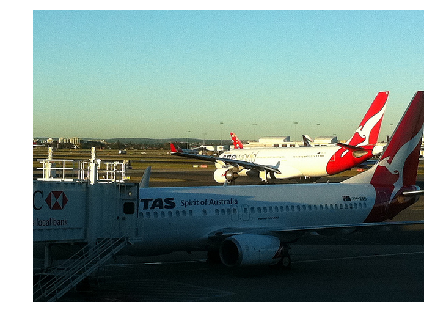

In [38]:
# sample more images from validation
for idx in np.random.choice(range(len(zipfile.ZipFile("val2014_sample.zip").filelist) - 1), 10):
    show_valid_example(val_img_fns, example_idx=idx)
    time.sleep(1)

You can download any image from the Internet and appply your model to it!

In [0]:
download_utils.download_file(
    "http://www.bijouxandbits.com/wp-content/uploads/2016/06/portal-cake-10.jpg",
    "portal-cake-10.jpg"
)

In [0]:
apply_model_to_image_raw_bytes(open("portal-cake-10.jpg", "rb").read())

Now it's time to find 10 examples where your model works good and 10 examples where it fails! 

You can use images from validation set as follows:
```python
show_valid_example(val_img_fns, example_idx=...)
```

You can use images from the Internet as follows:
```python
! wget ...
apply_model_to_image_raw_bytes(open("...", "rb").read())
```

If you use these functions, the output will be embedded into your notebook and will be visible during peer review!

When you're done, download your noteboook using "File" -> "Download as" -> "Notebook" and prepare that file for peer review!

In [0]:
import os

--2019-08-18 17:42:49--  https://www.seriouseats.com/images/2015/10/coffee-shutterstock_52699507.jpg
Resolving www.seriouseats.com (www.seriouseats.com)... 104.20.201.57, 104.20.200.57, 2606:4700:10::6814:c839, ...
Connecting to www.seriouseats.com (www.seriouseats.com)|104.20.201.57|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 142956 (140K) [image/jpeg]
Saving to: ‘coffee-shutterstock_52699507.jpg.3’

coffee-shutterstock 100%[===================>] 139.61K  --.-KB/s    in 0.008s  

2019-08-18 17:42:50 (17.4 MB/s) - ‘coffee-shutterstock_52699507.jpg.3’ saved [142956/142956]



/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


a coffee cup sitting on top of a table


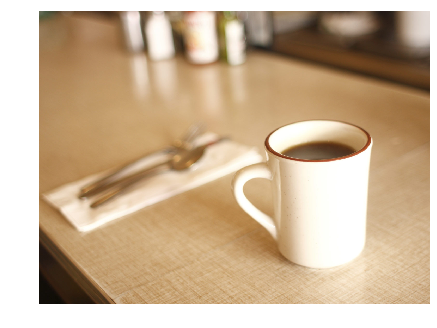

In [75]:
# Success 1/10 - Common daily life object just work, as they are likely to be part of or close to the training data.
!wget https://www.seriouseats.com/images/2015/10/coffee-shutterstock_52699507.jpg
apply_model_to_image_raw_bytes(open("coffee-shutterstock_52699507.jpg", "rb").read())

--2019-08-18 17:42:52--  http://www.gunjap.net/site/wp-content/uploads/2012/10/1660-1024x768.jpg
Resolving www.gunjap.net (www.gunjap.net)... 62.149.140.117
Connecting to www.gunjap.net (www.gunjap.net)|62.149.140.117|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 103974 (102K) [image/jpeg]
Saving to: ‘1660-1024x768.jpg.2’

1660-1024x768.jpg.2 100%[===================>] 101.54K   160KB/s    in 0.6s    

2019-08-18 17:42:53 (160 KB/s) - ‘1660-1024x768.jpg.2’ saved [103974/103974]



/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


a man in a helmet is riding a motorcycle


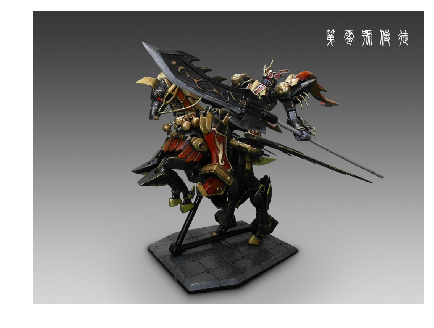

In [76]:
# Failure 1/10 - Fantasy animals and objects are unlikely to give great subtitles.
!wget http://www.gunjap.net/site/wp-content/uploads/2012/10/1660-1024x768.jpg
apply_model_to_image_raw_bytes(open("1660-1024x768.jpg", "rb").read())

--2019-08-18 17:42:55--  https://images.pexels.com/photos/415926/pexels-photo-415926.jpeg
Resolving images.pexels.com (images.pexels.com)... 104.17.209.102, 104.17.208.102, 2606:4700::6811:d166, ...
Connecting to images.pexels.com (images.pexels.com)|104.17.209.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 843488 (824K) [image/jpeg]
Saving to: ‘pexels-photo-415926.jpeg.2’

pexels-photo-415926 100%[===================>] 823.72K  --.-KB/s    in 0.03s   

2019-08-18 17:42:55 (27.8 MB/s) - ‘pexels-photo-415926.jpeg.2’ saved [843488/843488]



/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


a boat is docked in the grass near a building


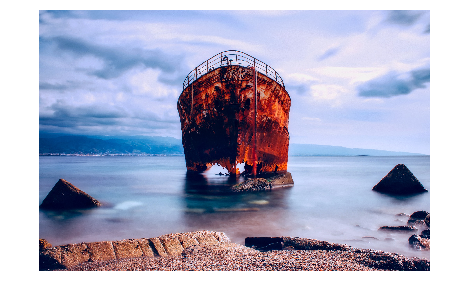

In [77]:
# Failure 2/10 - Overly stylized images are also unlikely to give convincing results.
!wget https://images.pexels.com/photos/415926/pexels-photo-415926.jpeg
apply_model_to_image_raw_bytes(open("pexels-photo-415926.jpeg", "rb").read())

In [78]:
# Failure 3/10 - Unusual objects in the training set.
!wget https://www.wikihow.com/images/6/66/Choose-Asian-Cooking-Utensils-Step-7.jpg
apply_model_to_image_raw_bytes(open("Choose-Asian-Cooking-Utensils-Step-7.jpg", "rb").read())

--2019-08-18 17:42:58--  https://www.wikihow.com/images/6/66/Choose-Asian-Cooking-Utensils-Step-7.jpg
Resolving www.wikihow.com (www.wikihow.com)... 151.101.54.110
Connecting to www.wikihow.com (www.wikihow.com)|151.101.54.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4908460 (4.7M) [image/jpeg]
Saving to: ‘Choose-Asian-Cooking-Utensils-Step-7.jpg.1’

Choose-Asian-Cookin 100%[===================>]   4.68M  --.-KB/s    in 0.06s   

2019-08-18 17:42:58 (76.0 MB/s) - ‘Choose-Asian-Cooking-Utensils-Step-7.jpg.1’ saved [4908460/4908460]



/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


a man is cutting a piece of paper with scissors


--2019-08-18 17:43:01--  https://upload.wikimedia.org/wikipedia/commons/2/24/StauntonKing2.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1019366 (995K) [image/jpeg]
Saving to: ‘StauntonKing2.jpg.1’

StauntonKing2.jpg.1 100%[===================>] 995.47K  --.-KB/s    in 0.1s    

2019-08-18 17:43:01 (8.53 MB/s) - ‘StauntonKing2.jpg.1’ saved [1019366/1019366]



/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


a group of three birds standing on top of a wall


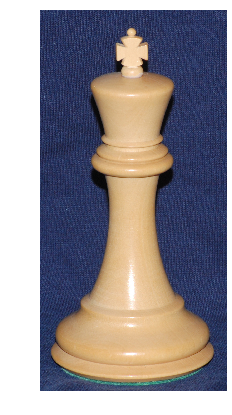

In [79]:
# Failure 4/10 - Unusualy large zoom on a perhaps rare object?
!wget https://upload.wikimedia.org/wikipedia/commons/2/24/StauntonKing2.jpg
apply_model_to_image_raw_bytes(open("StauntonKing2.jpg", "rb").read())

--2019-08-18 17:43:04--  http://hdimages.org/wp-content/uploads/2016/12/food-images-HD1.jpg
Resolving hdimages.org (hdimages.org)... 149.56.167.89
Connecting to hdimages.org (hdimages.org)|149.56.167.89|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 567095 (554K) [image/jpeg]
Saving to: ‘food-images-HD1.jpg.1’

food-images-HD1.jpg 100%[===================>] 553.80K  1.49MB/s    in 0.4s    

2019-08-18 17:43:04 (1.49 MB/s) - ‘food-images-HD1.jpg.1’ saved [567095/567095]



/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


a cutting board topped with vegetables and a knife


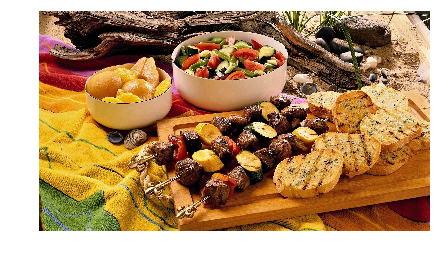

In [80]:
# Success 2/10 - Daily life scene, although the success if partial (no knife but unusual sticks).
!wget http://hdimages.org/wp-content/uploads/2016/12/food-images-HD1.jpg
apply_model_to_image_raw_bytes(open("food-images-HD1.jpg", "rb").read())

In [81]:
# Success 3/10 - Common daily life scene.
!wget https://ggwash.org/images/posts/_resized/5803352002_b03663cd22_o.jpg
apply_model_to_image_raw_bytes(open("5803352002_b03663cd22_o.jpg", "rb").read())

--2019-08-18 17:43:06--  https://ggwash.org/images/posts/_resized/5803352002_b03663cd22_o.jpg
Resolving ggwash.org (ggwash.org)... 104.25.210.35, 104.25.211.35, 2606:4700:20::6819:d223, ...
Connecting to ggwash.org (ggwash.org)|104.25.210.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 300357 (293K) [image/jpeg]
Saving to: ‘5803352002_b03663cd22_o.jpg.1’

5803352002_b03663cd 100%[===================>] 293.32K  --.-KB/s    in 0.02s   

2019-08-18 17:43:07 (18.6 MB/s) - ‘5803352002_b03663cd22_o.jpg.1’ saved [300357/300357]



/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


a train is parked at a train station


--2019-08-18 17:43:09--  https://s1.cdn.autoevolution.com/images/news/gallery/meet-the-best-looking-modern-bmw-the-z4-zagato-photo-gallery_14.jpg
Resolving s1.cdn.autoevolution.com (s1.cdn.autoevolution.com)... 69.16.175.42, 69.16.175.10
Connecting to s1.cdn.autoevolution.com (s1.cdn.autoevolution.com)|69.16.175.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 472024 (461K) [image/jpeg]
Saving to: ‘meet-the-best-looking-modern-bmw-the-z4-zagato-photo-gallery_14.jpg.1’

meet-the-best-looki 100%[===================>] 460.96K  --.-KB/s    in 0.02s   

2019-08-18 17:43:09 (20.0 MB/s) - ‘meet-the-best-looking-modern-bmw-the-z4-zagato-photo-gallery_14.jpg.1’ saved [472024/472024]



/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


a car that is parked in the grass


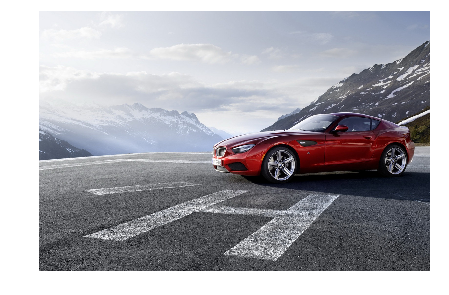

In [82]:
# Success 4/10 - Common daily life scene, although there is no grass.
!wget https://s1.cdn.autoevolution.com/images/news/gallery/meet-the-best-looking-modern-bmw-the-z4-zagato-photo-gallery_14.jpg
apply_model_to_image_raw_bytes(open("meet-the-best-looking-modern-bmw-the-z4-zagato-photo-gallery_14.jpg", "rb").read())

--2019-08-18 17:43:12--  https://www.awesomefiji.com/media/1106/blue-lagoon-resort-fiji-13.jpg
Resolving www.awesomefiji.com (www.awesomefiji.com)... 210.48.91.31
Connecting to www.awesomefiji.com (www.awesomefiji.com)|210.48.91.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 77254 (75K) [image/jpeg]
Saving to: ‘blue-lagoon-resort-fiji-13.jpg.1’

blue-lagoon-resort- 100%[===================>]  75.44K   206KB/s    in 0.4s    

2019-08-18 17:43:13 (206 KB/s) - ‘blue-lagoon-resort-fiji-13.jpg.1’ saved [77254/77254]

a boat is docked in the water near a boat dock


/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


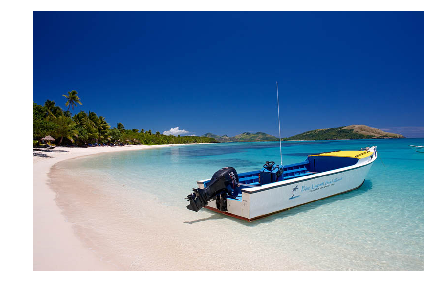

In [83]:
# Success 5/10 - Correctly docked in the water, although no boat dock later.
!wget https://www.awesomefiji.com/media/1106/blue-lagoon-resort-fiji-13.jpg
apply_model_to_image_raw_bytes(open("blue-lagoon-resort-fiji-13.jpg", "rb").read())

In [84]:
# Failure 5/10 - Unusual pizza.
!wget https://images.trvl-media.com/media/content/shared/images/travelguides/destination/7780/Butterfly-Pavilion-22587.jpg
apply_model_to_image_raw_bytes(open("Butterfly-Pavilion-22587.jpg", "rb").read())

--2019-08-18 17:43:15--  https://images.trvl-media.com/media/content/shared/images/travelguides/destination/7780/Butterfly-Pavilion-22587.jpg
Resolving images.trvl-media.com (images.trvl-media.com)... 104.100.87.105
Connecting to images.trvl-media.com (images.trvl-media.com)|104.100.87.105|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 90197 (88K) [image/jpeg]
Saving to: ‘Butterfly-Pavilion-22587.jpg.1’

Butterfly-Pavilion- 100%[===================>]  88.08K  --.-KB/s    in 0.05s   

2019-08-18 17:43:15 (1.84 MB/s) - ‘Butterfly-Pavilion-22587.jpg.1’ saved [90197/90197]



/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


a man is holding a piece of pizza in their hands


In [85]:
# Failure 6/10 - Surprisingly completely wrong.
!wget https://images.pexels.com/photos/382420/pexels-photo-382420.jpeg
apply_model_to_image_raw_bytes(open("pexels-photo-382420.jpeg", "rb").read())

--2019-08-18 17:43:17--  https://images.pexels.com/photos/382420/pexels-photo-382420.jpeg
Resolving images.pexels.com (images.pexels.com)... 104.17.209.102, 104.17.208.102, 2606:4700::6811:d166, ...
Connecting to images.pexels.com (images.pexels.com)|104.17.209.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4305822 (4.1M) [image/jpeg]
Saving to: ‘pexels-photo-382420.jpeg.1’

pexels-photo-382420 100%[===================>]   4.11M  --.-KB/s    in 0.05s   

2019-08-18 17:43:18 (83.8 MB/s) - ‘pexels-photo-382420.jpeg.1’ saved [4305822/4305822]



/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


a person on a horse on a snowy street


In [86]:
# Success 6/10 - Common scene, with vague interpretation of "in the air".
!wget https://s1.cdn.autoevolution.com/images/news/gallery/arai-reveals-joey-dunlop-limited-run-tribute-helmet_4.jpg
apply_model_to_image_raw_bytes(open("arai-reveals-joey-dunlop-limited-run-tribute-helmet_4.jpg", "rb").read())

--2019-08-18 17:43:21--  https://s1.cdn.autoevolution.com/images/news/gallery/arai-reveals-joey-dunlop-limited-run-tribute-helmet_4.jpg
Resolving s1.cdn.autoevolution.com (s1.cdn.autoevolution.com)... 69.16.175.42, 69.16.175.10
Connecting to s1.cdn.autoevolution.com (s1.cdn.autoevolution.com)|69.16.175.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 465677 (455K) [image/jpeg]
Saving to: ‘arai-reveals-joey-dunlop-limited-run-tribute-helmet_4.jpg.1’

arai-reveals-joey-d 100%[===================>] 454.76K  --.-KB/s    in 0.02s   

2019-08-18 17:43:22 (19.1 MB/s) - ‘arai-reveals-joey-dunlop-limited-run-tribute-helmet_4.jpg.1’ saved [465677/465677]



/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


a person on a motorcycle in the air


--2019-08-18 17:43:24--  http://images.huffingtonpost.com/2014-01-23-SimpleGlobalEamesLivingRoom.jpg
Resolving images.huffingtonpost.com (images.huffingtonpost.com)... 192.229.210.207, 2606:2800:21f:2317:1818:390:aaa:218f
Connecting to images.huffingtonpost.com (images.huffingtonpost.com)|192.229.210.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1577356 (1.5M) [image/jpeg]
Saving to: ‘2014-01-23-SimpleGlobalEamesLivingRoom.jpg.1’

2014-01-23-SimpleGl 100%[===================>]   1.50M  --.-KB/s    in 0.04s   

2019-08-18 17:43:24 (35.3 MB/s) - ‘2014-01-23-SimpleGlobalEamesLivingRoom.jpg.1’ saved [1577356/1577356]



/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


a living room with a couch and a television


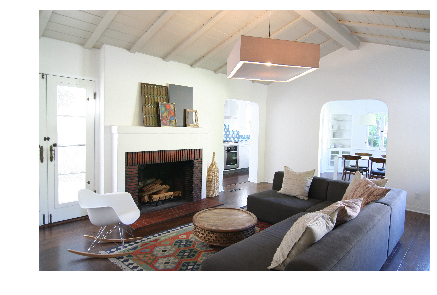

In [87]:
# Success 7/10 - A common living room, although the TV is very analogue.
!wget http://images.huffingtonpost.com/2014-01-23-SimpleGlobalEamesLivingRoom.jpg
apply_model_to_image_raw_bytes(open("2014-01-23-SimpleGlobalEamesLivingRoom.jpg", "rb").read())

--2019-08-18 17:43:27--  http://drabtofabdesign.com/wp-content/uploads/2018/02/Traditional-Guest-Room-Design-and-ideas-Setup-ideas-for-small-Guest-Room.jpg
Resolving drabtofabdesign.com (drabtofabdesign.com)... 162.246.59.148
Connecting to drabtofabdesign.com (drabtofabdesign.com)|162.246.59.148|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 141628 (138K) [image/jpeg]
Saving to: ‘Traditional-Guest-Room-Design-and-ideas-Setup-ideas-for-small-Guest-Room.jpg.1’

Traditional-Guest-R 100%[===================>] 138.31K   680KB/s    in 0.2s    

2019-08-18 17:43:27 (680 KB/s) - ‘Traditional-Guest-Room-Design-and-ideas-Setup-ideas-for-small-Guest-Room.jpg.1’ saved [141628/141628]



/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


a bedroom with a bed and a lamp


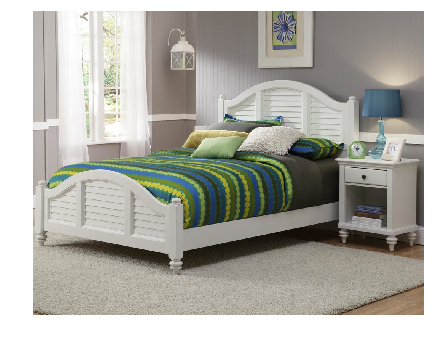

In [88]:
# Success 8/10 - Common daily life and simple room.
!wget http://drabtofabdesign.com/wp-content/uploads/2018/02/Traditional-Guest-Room-Design-and-ideas-Setup-ideas-for-small-Guest-Room.jpg
apply_model_to_image_raw_bytes(open("Traditional-Guest-Room-Design-and-ideas-Setup-ideas-for-small-Guest-Room.jpg", "rb").read())

--2019-08-18 17:43:29--  https://s3.caradvice.com.au/wp-content/uploads/2017/05/2017-kia-cerato-sport-26.jpg
Resolving s3.caradvice.com.au (s3.caradvice.com.au)... 104.20.15.72, 104.20.14.72, 2606:4700:10::6814:f48, ...
Connecting to s3.caradvice.com.au (s3.caradvice.com.au)|104.20.15.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 713109 (696K) [image/jpeg]
Saving to: ‘2017-kia-cerato-sport-26.jpg.1’

2017-kia-cerato-spo 100%[===================>] 696.40K  --.-KB/s    in 0.02s   

2019-08-18 17:43:29 (28.8 MB/s) - ‘2017-kia-cerato-sport-26.jpg.1’ saved [713109/713109]



/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


a car parked in a parking lot next to a fire hydrant


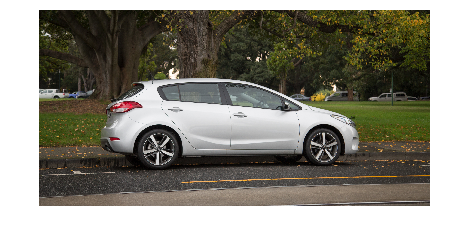

In [89]:
# Success 9/10 - Common scene, although the system invents objects that don't exist.
!wget https://s3.caradvice.com.au/wp-content/uploads/2017/05/2017-kia-cerato-sport-26.jpg
apply_model_to_image_raw_bytes(open("2017-kia-cerato-sport-26.jpg", "rb").read())

--2019-08-18 17:43:32--  http://1.bp.blogspot.com/-9KsYbqudYhE/TsSx_tXv6QI/AAAAAAAADpc/LC5zgvI9WO4/s1600/sport-desktop-wallpapers-photo-images-13.jpg
Resolving 1.bp.blogspot.com (1.bp.blogspot.com)... 74.125.20.132, 2607:f8b0:400e:c09::84
Connecting to 1.bp.blogspot.com (1.bp.blogspot.com)|74.125.20.132|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 229854 (224K) [image/jpeg]
Saving to: ‘sport-desktop-wallpapers-photo-images-13.jpg.1’

sport-desktop-wallp 100%[===================>] 224.47K  --.-KB/s    in 0.001s  

2019-08-18 17:43:32 (367 MB/s) - ‘sport-desktop-wallpapers-photo-images-13.jpg.1’ saved [229854/229854]



/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


a man is jumping in the air with a basketball in his hand


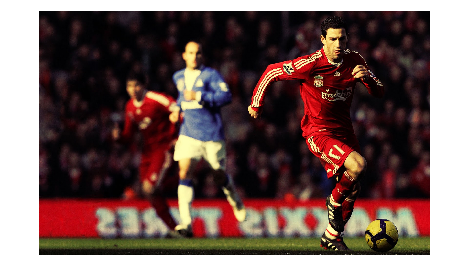

In [90]:
# Failure 7/10 - A common basketball scene?
!wget http://1.bp.blogspot.com/-9KsYbqudYhE/TsSx_tXv6QI/AAAAAAAADpc/LC5zgvI9WO4/s1600/sport-desktop-wallpapers-photo-images-13.jpg
apply_model_to_image_raw_bytes(open("sport-desktop-wallpapers-photo-images-13.jpg", "rb").read())

--2019-08-18 17:43:35--  https://www.pes-patch.com/wp-content/uploads/2015/04/New-Scoreboard-with-Sky-Sport-TV-Logo-by-ljq12697-2.jpg
Resolving www.pes-patch.com (www.pes-patch.com)... 151.80.21.182
Connecting to www.pes-patch.com (www.pes-patch.com)|151.80.21.182|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 307624 (300K) [image/jpeg]
Saving to: ‘New-Scoreboard-with-Sky-Sport-TV-Logo-by-ljq12697-2.jpg.1’

New-Scoreboard-with 100%[===================>] 300.41K   538KB/s    in 0.6s    

2019-08-18 17:43:36 (538 KB/s) - ‘New-Scoreboard-with-Sky-Sport-TV-Logo-by-ljq12697-2.jpg.1’ saved [307624/307624]



/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


a person standing on a beach with a kite


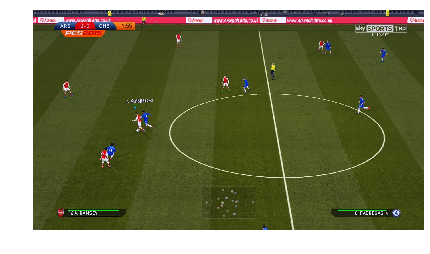

In [91]:
# Failure 8/10 - Artifical images can really be challenging.
!wget https://www.pes-patch.com/wp-content/uploads/2015/04/New-Scoreboard-with-Sky-Sport-TV-Logo-by-ljq12697-2.jpg
apply_model_to_image_raw_bytes(open("New-Scoreboard-with-Sky-Sport-TV-Logo-by-ljq12697-2.jpg", "rb").read())

--2019-08-18 17:43:38--  https://louishotels.com/_novaimg/galleria/1214911.jpg
Resolving louishotels.com (louishotels.com)... 34.200.40.164
Connecting to louishotels.com (louishotels.com)|34.200.40.164|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 222008 (217K) [image/jpeg]
Saving to: ‘1214911.jpg.1’

1214911.jpg.1       100%[===================>] 216.80K   866KB/s    in 0.3s    

2019-08-18 17:43:38 (866 KB/s) - ‘1214911.jpg.1’ saved [222008/222008]



/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


a man standing on a beach holding a surfboard


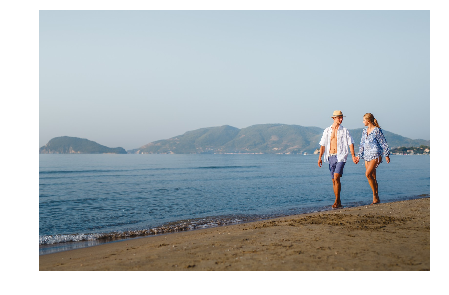

In [92]:
# Failure 9/10 - Poor board.
!wget https://louishotels.com/_novaimg/galleria/1214911.jpg
apply_model_to_image_raw_bytes(open("1214911.jpg", "rb").read())

--2019-08-18 17:43:40--  http://i.ebayimg.com/images/i/121476953065-0-1/s-l1000.jpg
Resolving i.ebayimg.com (i.ebayimg.com)... 23.44.160.209, 2600:1406:3:488::24d4, 2600:1406:3:497::24d4
Connecting to i.ebayimg.com (i.ebayimg.com)|23.44.160.209|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 77539 (76K) [image/jpeg]
Saving to: ‘s-l1000.jpg.1’

s-l1000.jpg.1       100%[===================>]  75.72K  --.-KB/s    in 0.01s   

2019-08-18 17:43:41 (5.13 MB/s) - ‘s-l1000.jpg.1’ saved [77539/77539]



/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


a person s hand holding a knife cutting a piece of paper


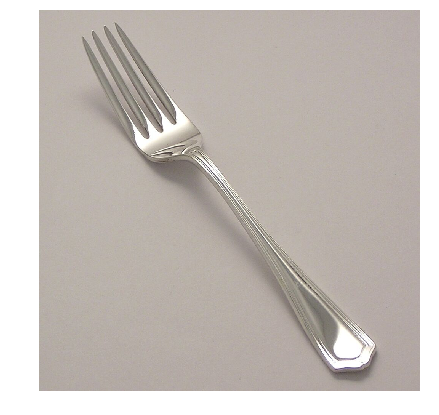

In [93]:
# Failure 10/10 - A common object, perhaps in an unnatural setting with respect to training data.
!wget http://i.ebayimg.com/images/i/121476953065-0-1/s-l1000.jpg
apply_model_to_image_raw_bytes(open("s-l1000.jpg", "rb").read())

In [94]:
# Failure 11/10 - Just a check: The system really does not like cutlery.
!wget https://image.freepik.com/free-photo/silverware-fork-spoon-and-paper-put-on-wooden-dining-table-set-in-left-hand-focused-for-make-copy-space-on-right-hand-image-for-make-food-concept-background_3249-1559.jpg
apply_model_to_image_raw_bytes(open("silverware-fork-spoon-and-paper-put-on-wooden-dining-table-set-in-left-hand-focused-for-make-copy-space-on-right-hand-image-for-make-food-concept-background_3249-1559.jpg", "rb").read())

--2019-08-18 17:43:43--  https://image.freepik.com/free-photo/silverware-fork-spoon-and-paper-put-on-wooden-dining-table-set-in-left-hand-focused-for-make-copy-space-on-right-hand-image-for-make-food-concept-background_3249-1559.jpg
Resolving image.freepik.com (image.freepik.com)... 184.27.37.251, 2600:1406:e800:487::30ec, 2600:1406:e800:49e::30ec
Connecting to image.freepik.com (image.freepik.com)|184.27.37.251|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 79559 (78K) [image/jpeg]
Saving to: ‘silverware-fork-spoon-and-paper-put-on-wooden-dining-table-set-in-left-hand-focused-for-make-copy-space-on-right-hand-image-for-make-food-concept-background_3249-1559.jpg.1’

silverware-fork-spo 100%[===================>]  77.69K   510KB/s    in 0.2s    

2019-08-18 17:43:44 (510 KB/s) - ‘silverware-fork-spoon-and-paper-put-on-wooden-dining-table-set-in-left-hand-focused-for-make-copy-space-on-right-hand-image-for-make-food-concept-background_3249-1559.jpg.1’ saved [79

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


a pair of scissors and a needle thread thread and scissor


--2019-08-18 17:43:46--  https://fortunedotcom.files.wordpress.com/2014/10/162211334.jpg
Resolving fortunedotcom.files.wordpress.com (fortunedotcom.files.wordpress.com)... 192.0.72.30, 192.0.72.31
Connecting to fortunedotcom.files.wordpress.com (fortunedotcom.files.wordpress.com)|192.0.72.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1121125 (1.1M) [image/jpeg]
Saving to: ‘162211334.jpg.1’

162211334.jpg.1     100%[===================>]   1.07M  --.-KB/s    in 0.1s    

2019-08-18 17:43:47 (7.50 MB/s) - ‘162211334.jpg.1’ saved [1121125/1121125]



/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


a bunch of bananas are hanging from a hook


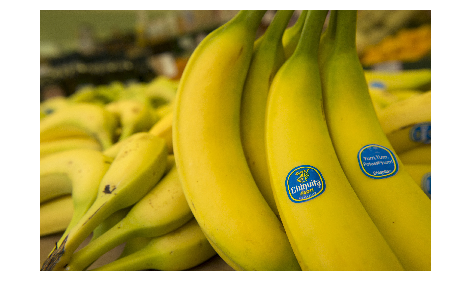

In [95]:
# Success 10/10 - Common subject.
!wget https://fortunedotcom.files.wordpress.com/2014/10/162211334.jpg
apply_model_to_image_raw_bytes(open("162211334.jpg", "rb").read())

In [96]:
# Success 11/10 - When we can compare apple with oranges.
!wget http://static.soposted.com/uploads/2017/11/fruit-medly_Gk-pT8dO-1.jpg
apply_model_to_image_raw_bytes(open("fruit-medly_Gk-pT8dO-1.jpg", "rb").read())

--2019-08-18 17:43:49--  http://static.soposted.com/uploads/2017/11/fruit-medly_Gk-pT8dO-1.jpg
Resolving static.soposted.com (static.soposted.com)... 99.86.32.74, 99.86.32.204, 99.86.32.112, ...
Connecting to static.soposted.com (static.soposted.com)|99.86.32.74|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1148350 (1.1M) [image/jpeg]
Saving to: ‘fruit-medly_Gk-pT8dO-1.jpg.1’

fruit-medly_Gk-pT8d 100%[===================>]   1.09M  --.-KB/s    in 0.04s   

2019-08-18 17:43:49 (27.3 MB/s) - ‘fruit-medly_Gk-pT8dO-1.jpg.1’ saved [1148350/1148350]



/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


a bowl of apples and a banana on a table


That's it! 

Congratulations, you've trained your image captioning model and now can produce captions for any picture from the  Internet!